In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from msc_project.utils import data_utils as du
import os
import pickle
import torch

plt.style.use('ggplot')

In [ ]:
DATA_DIR = '/scratch/msc24h18/msc_project/results/test23'

summary_files = du.get_summary_files(DATA_DIR)
weights_files = du.get_files(DATA_DIR, 'pkl', 'weights')

summaries = [du.read_summary_file(f)[0] for f in summary_files]
weights = [pickle.load(open(f, 'rb')) for f in weights_files]

# first layer is split into two (256,392) layers, so combine them into one (256,784)
for w in weights:
    for w_i in w:
        t1 = w_i['0.analog_module.array.0.0'][0]
        t2 = w_i['0.analog_module.array.1.0'][0]
        t3 = torch.cat([t1, t2], dim=1)
        new_weight = (t3, None)
        w_i.pop('0.analog_module.array.0.0', None)
        w_i.pop('0.analog_module.array.1.0', None)
        w_i['0.analog_module'] = new_weight
        w_i.move_to_end('0.analog_module', last=False)


In [216]:
def _plot_weight_hist(ax, w, layers=(True, True, True), label=None, color=None):
    l1 = w['0.analog_module'][0]
    l2 = w['2.analog_module'][0]
    l3 = w['4.analog_module'][0]

    if layers[0]:
        ax.hist(l1.flatten(), bins=100, alpha=0.5, label=label, color=color)
    if layers[1]:
        ax.hist(l2.flatten(), bins=100, alpha=0.5, label=label, color=color)
    if layers[2]:
        ax.hist(l3.flatten(), bins=100, alpha=0.5, label=label, color=color)

def plot_weight_hist(weights, labels=None, suptitle=None, huevals=None, cmap=None, norm=None):
    fig, ax = plt.subplots(3, 2, figsize=(15, 20))
    if labels is None:
        labels = [''] * len(weights)
    if huevals is None:
        colors = [None] * len(weights)
    else:
        colors = [cmap(norm(h)) for h in huevals]
    for weight, label, color in zip(weights, labels, colors):
        for row, rax in enumerate(ax):
            layers = (row == 0, row == 1, row == 2)
            for col, cax in enumerate(rax):
                w_idx = 0 if col == 0 else -1
                _plot_weight_hist(cax, weight[w_idx], layers=layers, label=label, color=color)
                cax.set(title=f"Layer {row} {'Initial' if w_idx == 0 else 'Final'}")
                cax.legend()
                cax.set(xlabel='Weight', ylabel='Count', xlim=(-1.5, 1.5))

    fig.suptitle(suptitle)
    plt.tight_layout()

    plt.show()

def animate_weight_hist(weights, labels=None, suptitle='', huevals=None, cmap=None, norm=None):
    fig, ax = plt.subplots(3, 1, figsize=(10, 20), sharex=True)
    ax[0].set(ylabel='Count', xlim=(-1.5, 1.5), title='Layer 0')
    ax[1].set(ylabel='Count', xlim=(-1.5, 1.5), title='Layer 1')
    ax[2].set(xlabel='Weight', ylabel='Count', xlim=(-1.5, 1.5), title='Layer 2')
    fig.suptitle(f"{suptitle} - Epoch 0", fontsize=16, y=0.92)

    if labels is None:
        labels = [''] * len(weights)
    if huevals is None:
        colors = [None] * len(weights)
    else:
        colors = [cmap(norm(h)) for h in huevals]

    def get_frame(i):
        ax[0].cla()
        ax[1].cla()
        ax[2].cla()
        ax[0].set(ylabel='Count', xlim=(-1.5, 1.5), title='Layer 0')
        ax[1].set(ylabel='Count', xlim=(-1.5, 1.5), title='Layer 1')
        ax[2].set(xlabel='Weight', ylabel='Count', xlim=(-1.5, 1.5), title='Layer 2')
        for weight, label, color in zip(weights, labels, colors):
            for row, rax in enumerate(ax):
                layers = (row == 0, row == 1, row == 2)
                _plot_weight_hist(rax, weight[i], layers=layers, label=label, color=color)
                rax.legend()
        fig.suptitle(f"{suptitle} - Epoch {i}", fontsize=16, y=0.92)

    anim = animation.FuncAnimation(fig, get_frame, frames=len(weights[0]), repeat=False)
    anim.save(f'{suptitle}.gif', writer='ffmpeg', fps=5)


In [217]:
def filter_data(filter_col = 'device_id', filter_val = 'ID294YR'):
    filtered_summaries = []
    filtered_weights = []
    for s, w in zip(summaries, weights):
        if s[filter_col] == filter_val:
            filtered_summaries.append(s)
            filtered_weights.append(w)

    return filtered_summaries, filtered_weights

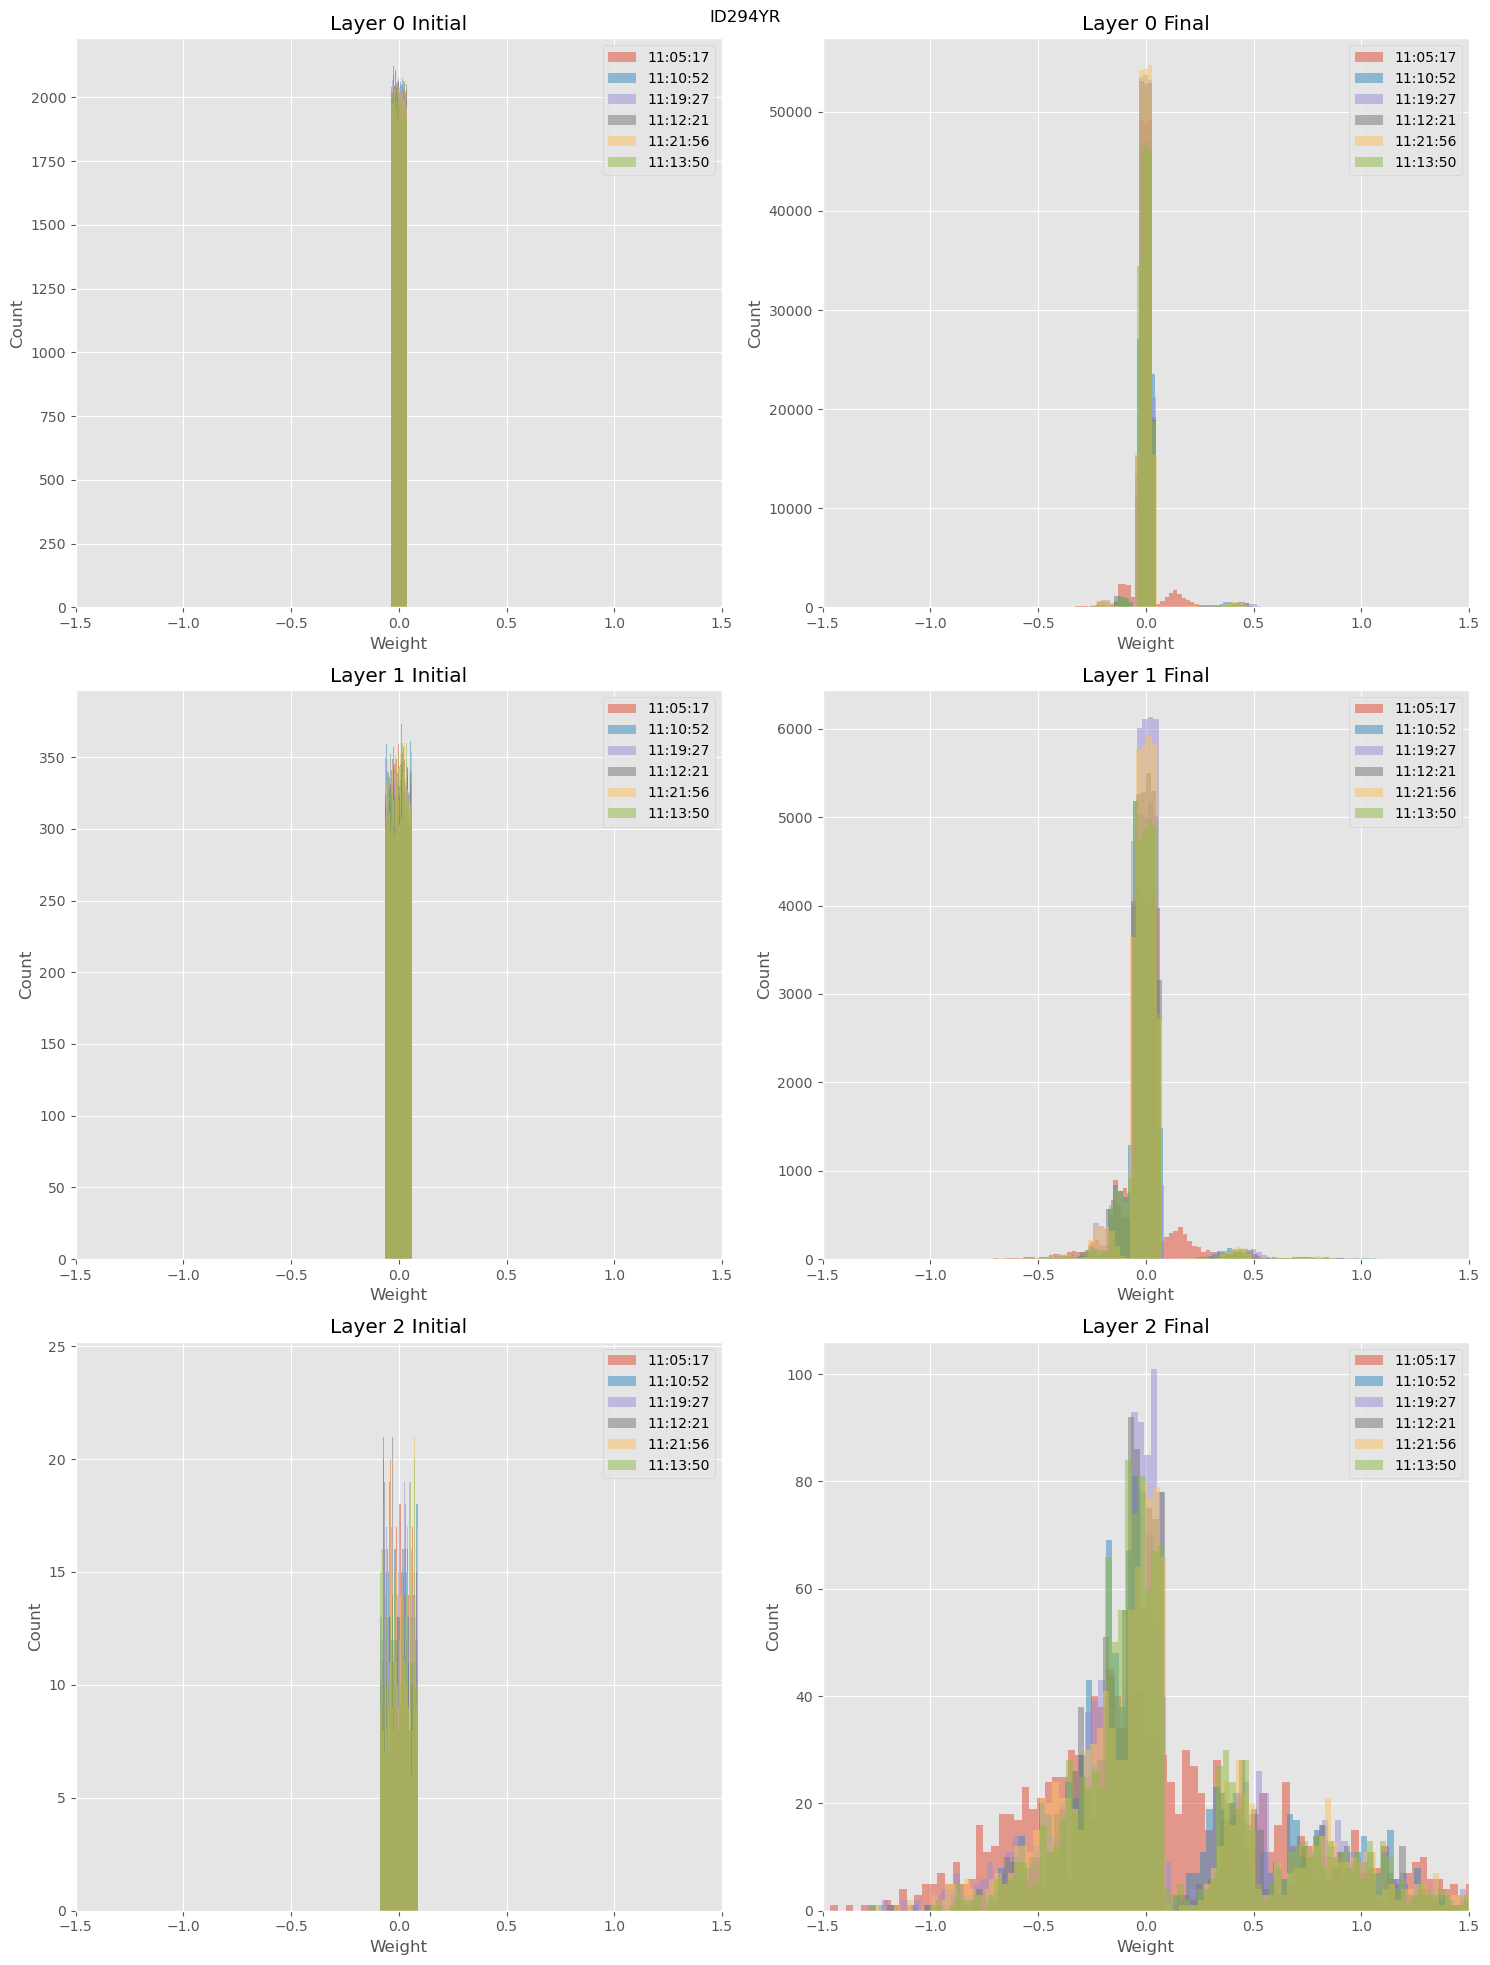

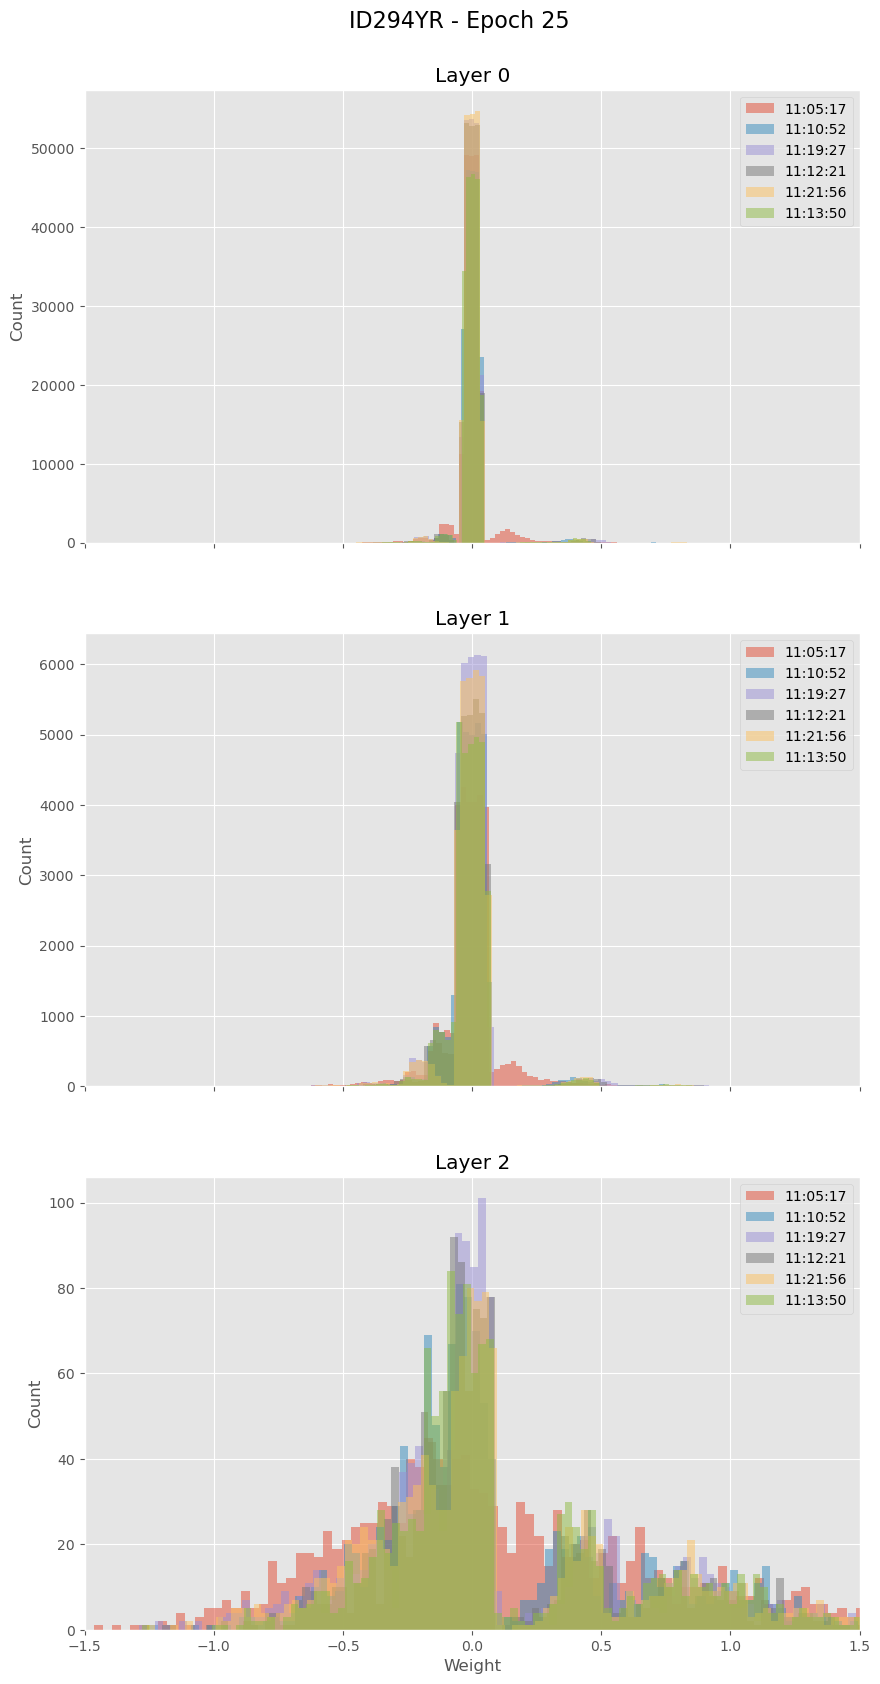

In [218]:
filtered_summaries, filtered_weights = filter_data(filter_col='device_id', filter_val='ID294YR')
plot_weight_hist(filtered_weights, labels=[s['test_time'] for s in filtered_summaries], suptitle='ID294YR')
animate_weight_hist(filtered_weights, labels=[s['test_time'] for s in filtered_summaries], suptitle='ID294YR')

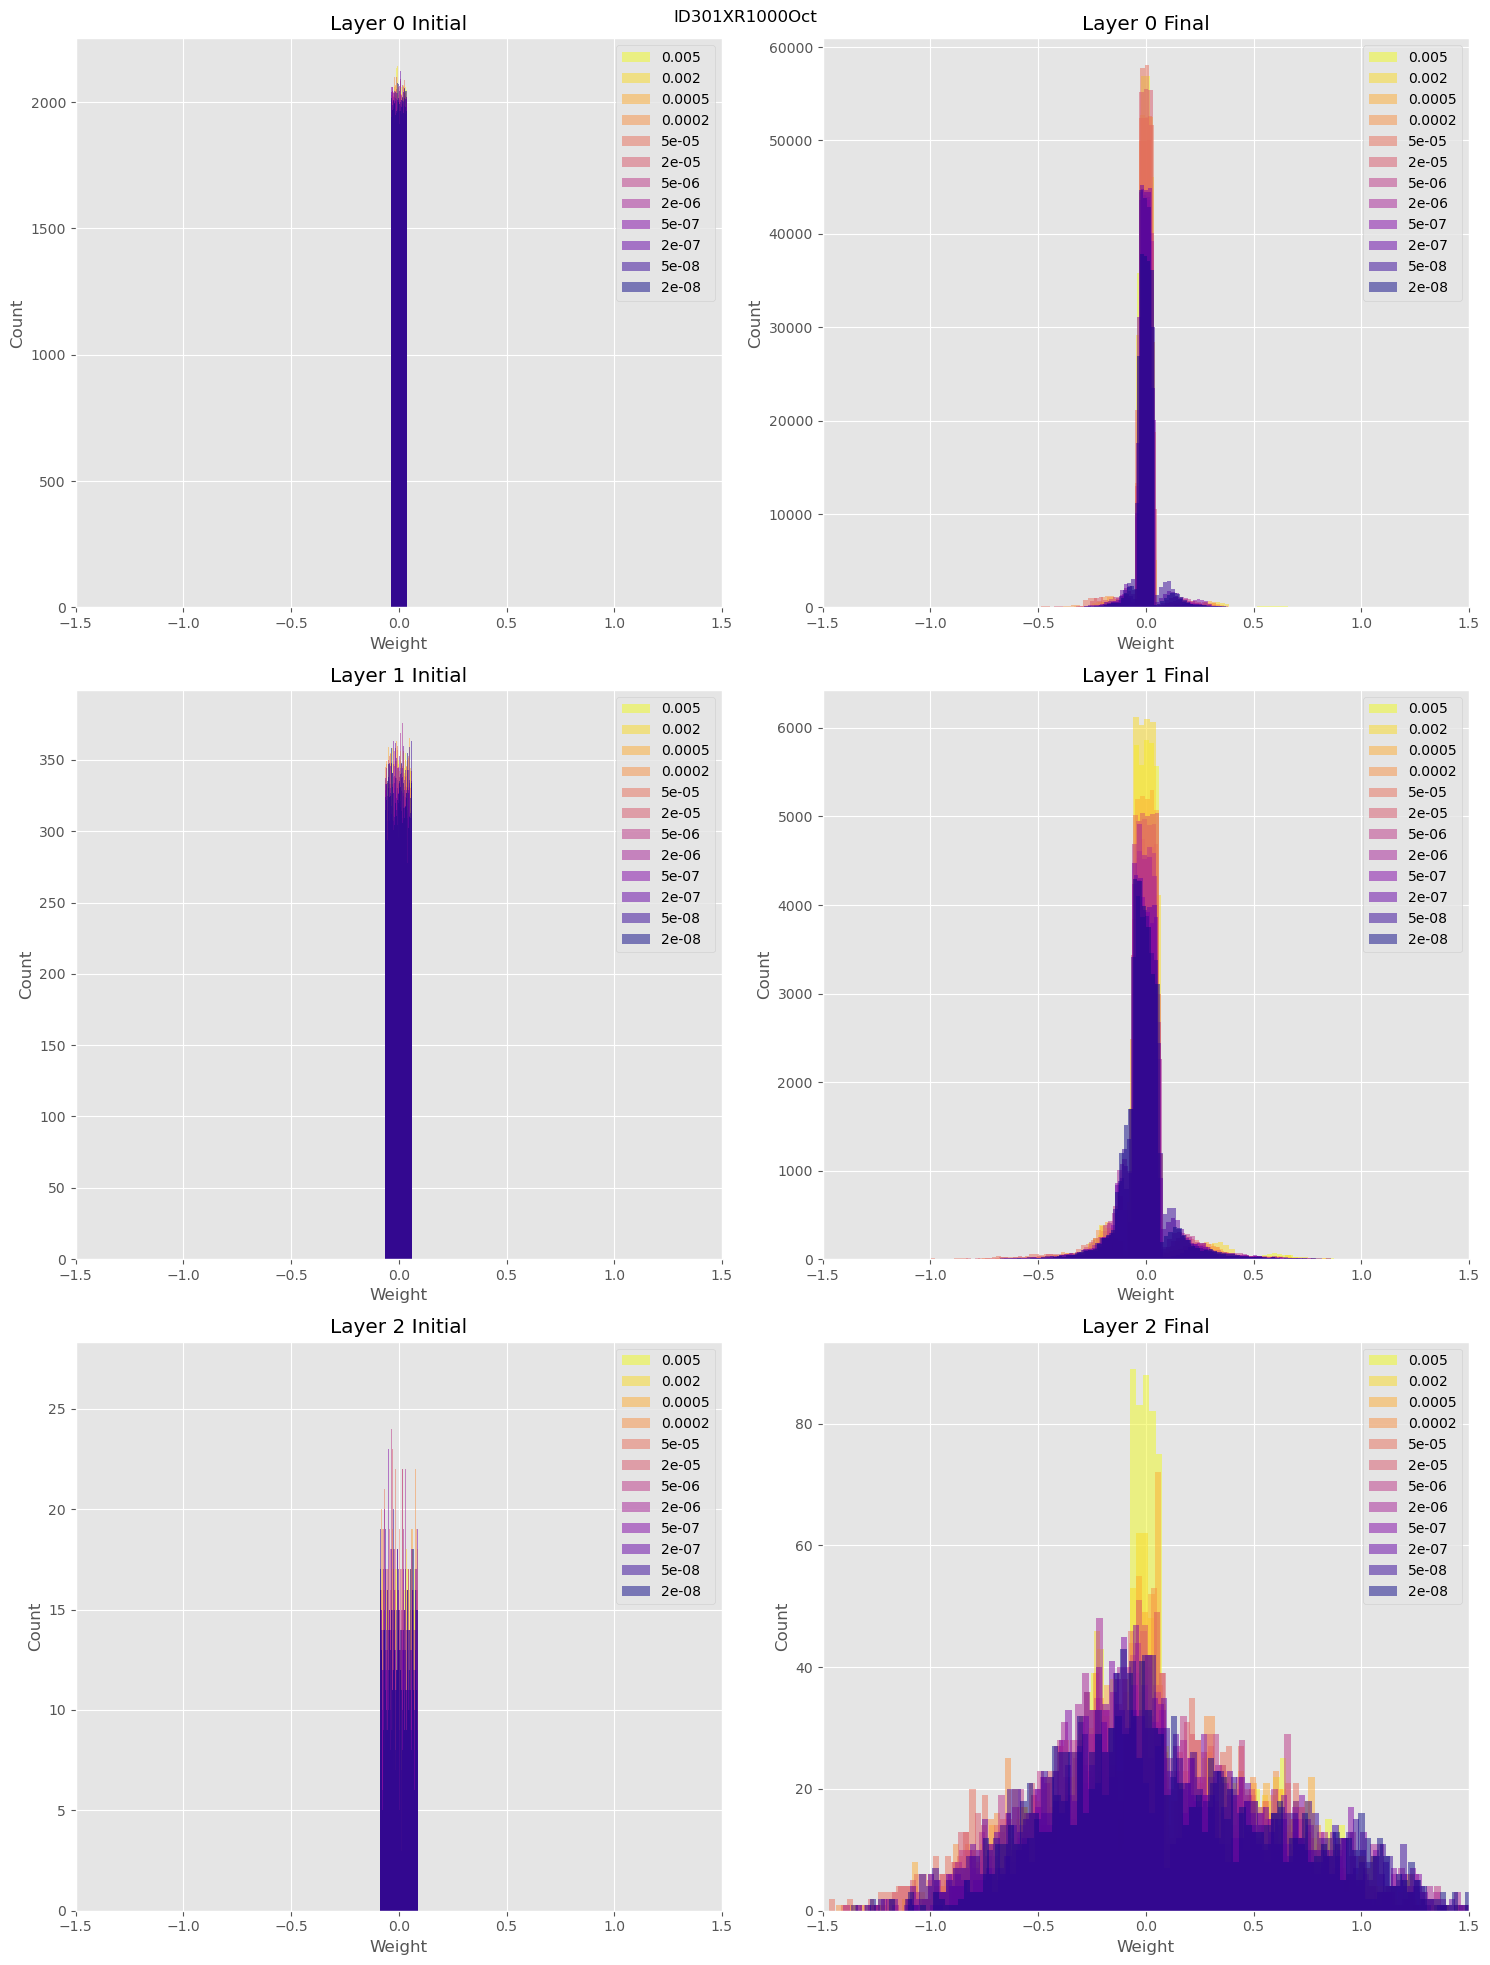

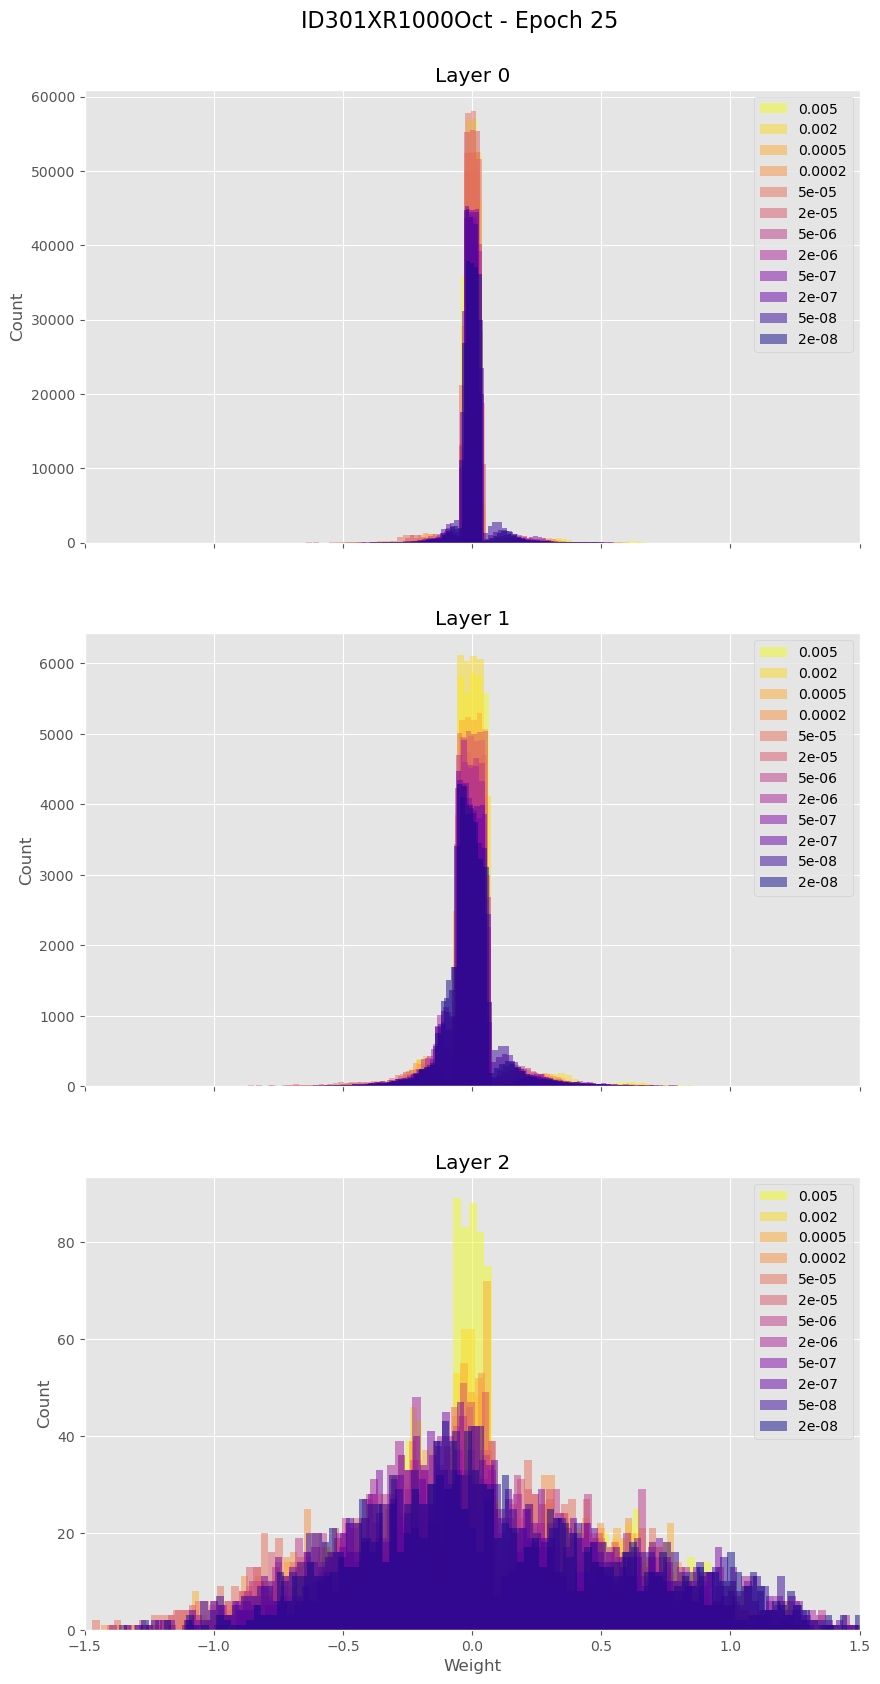

In [219]:
filtered_summaries, filtered_weights = filter_data(filter_col='device_id', filter_val='ID301XR1000Oct')

huevals = np.array([float(s['pulseWidth']) for s in filtered_summaries])
cmap = mpl.colormaps['plasma']
norm = mpl.colors.LogNorm(huevals.min(), huevals.max())

plot_weight_hist(filtered_weights, labels=[s['pulseWidth'] for s in filtered_summaries], suptitle='ID301XR1000Oct', huevals=huevals, cmap=cmap, norm=norm)
animate_weight_hist(filtered_weights, labels=[s['pulseWidth'] for s in filtered_summaries], suptitle='ID301XR1000Oct', huevals=huevals, cmap=cmap, norm=norm)

In [ ]:
# create animation